In [1]:
from gensim.models import Doc2Vec
import pandas as pd
model = Doc2Vec.load('./surveyVectors.d2v')

C:\Users\Vilma\Anaconda3\envs\tensorflow\lib\site-packages\gensim\utils.py:865: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


In [2]:
df = pd.read_pickle('vectorComments')

In [3]:
print (df.head(1))

   sentiment                                            comment  \
0          1  She present class materials with powerpoint wh...   

                                 vectorized_comments  
0  [0.0368987, -0.134596, 0.0120176, -0.0541564, ...  


In [4]:
#Cross validation
from sklearn import cross_validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pickle

#metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

# classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier

#plot
import matplotlib.pyplot as plt

C:\Users\Vilma\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Model with knn:
- doc2vec vectors
- k values used are 2, 3, 7, 9
- Cross validation fold=5

In [5]:
skf = StratifiedKFold(n_splits=5)

In [6]:
#This stores a list from 1 to 10, which will be used as k values from 1 to 10
k_range=list(range(1,10))
print(k_range)

[1, 2, 3, 4, 5, 6, 7, 8, 9]


In [7]:
#Creates a dictionary, tuple of the key of nn and its values
param_grid = dict(n_neighbors=k_range)
print(param_grid)

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9]}


In [8]:
#Create knn classifier
knn=KNeighborsClassifier()

In [9]:
#Use knn classifier, parameters from param_grid, k-fold = 10, and precision as the metrics score
grid=GridSearchCV(knn,param_grid,cv=StratifiedKFold(n_splits=5),scoring='f1')

In [10]:
#Convert data arrays to lists
X=df["vectorized_comments"].T.tolist()
y=df["sentiment"].T.tolist()

In [11]:
#use the classifier 'grid' created in line 15 to fit our data
#X - represents the comments
#y - represents the labels (1 or 0)
grid.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

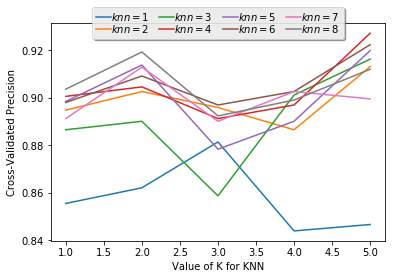

In [12]:
# plot the results of all folds for all knn values, for an specific metric
labels = []
for i in range(1,9):
    plt.plot([1,2,3,4,5], grid.grid_scores_[i].cv_validation_scores)
    labels.append(r'$knn = %i$' % (i))

plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Precision')
plt.legend(labels,ncol=4, loc='upper center', bbox_to_anchor=[0.5, 1.1], 
           columnspacing=1.0, labelspacing=0.0, handletextpad=0.0,
           handlelength=1.5, fancybox=True, shadow=True)
plt.show()

In [13]:
# view the complete results (list of named tuples)
#Shows the mean value for each k value, as well as the standard deviation, and its parameters
grid.grid_scores_

[mean: 0.89016, std: 0.02070, params: {'n_neighbors': 1},
 mean: 0.85794, std: 0.01338, params: {'n_neighbors': 2},
 mean: 0.89848, std: 0.00887, params: {'n_neighbors': 3},
 mean: 0.89041, std: 0.01898, params: {'n_neighbors': 4},
 mean: 0.90396, std: 0.01233, params: {'n_neighbors': 5},
 mean: 0.89998, std: 0.01518, params: {'n_neighbors': 6},
 mean: 0.90570, std: 0.00931, params: {'n_neighbors': 7},
 mean: 0.89922, std: 0.00830, params: {'n_neighbors': 8},
 mean: 0.90517, std: 0.00947, params: {'n_neighbors': 9}]

In [14]:
# examine the first tuple, when k=1
print(grid.grid_scores_[2].parameters)
print(grid.grid_scores_[2].cv_validation_scores)
print(grid.grid_scores_[2].mean_validation_score)
print(len(grid.grid_scores_))

{'n_neighbors': 3}
[ 0.89473684  0.9025641   0.89583333  0.88648649  0.91304348]
0.8984794024
9


In [15]:
# create a list of the mean scores only
grid_mean_scores = [result.mean_validation_score for result in grid.grid_scores_]
print(grid_mean_scores)

[0.89016160862375782, 0.85793603154036224, 0.89847940240006308, 0.89041226462821188, 0.90396083337865485, 0.89997663197141597, 0.90569939541911004, 0.89921899171206077, 0.90516721145802115]


In [16]:
# examine the best model
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.905699395419
{'n_neighbors': 7}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')


In [17]:
from sklearn.metrics import confusion_matrix
y_pred = grid.best_estimator_.predict(X)
print(y)
print(y_pred)
print(confusion_matrix(y, y_pred))

[1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 

## Model with Random Forest Classifier (RFC)
A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting.

bootstrap = [True] ---> samples are drawn with replacement if bootstrap=True (default).

In [18]:
parameters = {
    'n_estimators': [200,400],
    'min_samples_leaf': [1],
    'min_samples_split': [2]
}

clf = GridSearchCV(RFC(verbose=1,n_jobs=1), param_grid=parameters, cv=StratifiedKFold(n_splits=5), scoring='f1')
clf.fit(X, y)

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=1, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [2], 'n_estimators': [200, 400], 'min_samples_leaf': [1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [19]:
# create a list of the mean scores only
grid_mean_scores = [result.mean_validation_score for result in clf.grid_scores_]
print(grid_mean_scores,"Mean of all scores for each cv fold")

[0.90641130497582734, 0.91099686715146255] Mean of all scores for each cv fold


In [20]:
# examine the best model
print(clf.best_score_)
print(clf.best_params_)
print(clf.best_estimator_)

0.910996867151
{'min_samples_split': 2, 'n_estimators': 400, 'min_samples_leaf': 1}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=400, n_jobs=1, oob_score=False, random_state=None,
            verbose=1, warm_start=False)


In [21]:
y1_pred = clf.best_estimator_.predict(X)
print(confusion_matrix(y, y1_pred))

[[ 89   0]
 [  0 454]]


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.1s finished


## Stochastic Gradient Descent Classifier (SGDC)


In [22]:
# Setup 5-fold stratified cross validation
cross_v = StratifiedKFold(n_splits=5) #Takes group information into account to avoid building folds with imbalanced class distributions (for binary or multiclass classification tasks).

In [23]:
# Define a parameter grid to search over
param_grid = {
    'alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1],
    'loss': ('log', 'hinge'), #function that gives the amount of error rate
    'penalty': ['l1', 'l2', 'elasticnet']
    }

In [24]:
#Create SGDC classifier using logistic regression and hinge
grid_search = GridSearchCV(SGDClassifier(), param_grid=param_grid, cv=cross_v, scoring='f1')

In [25]:
#Fit model to the data
grid_search.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2', 'elasticnet'], 'loss': ('log', 'hinge'), 'alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [26]:
# create a list of the mean scores only
grid_search.grid_scores_

[mean: 0.88819, std: 0.02382, params: {'penalty': 'l1', 'loss': 'log', 'alpha': 0.0001},
 mean: 0.89826, std: 0.01197, params: {'penalty': 'l2', 'loss': 'log', 'alpha': 0.0001},
 mean: 0.84380, std: 0.04515, params: {'penalty': 'elasticnet', 'loss': 'log', 'alpha': 0.0001},
 mean: 0.74550, std: 0.24252, params: {'penalty': 'l1', 'loss': 'hinge', 'alpha': 0.0001},
 mean: 0.89636, std: 0.03074, params: {'penalty': 'l2', 'loss': 'hinge', 'alpha': 0.0001},
 mean: 0.89873, std: 0.01271, params: {'penalty': 'elasticnet', 'loss': 'hinge', 'alpha': 0.0001},
 mean: 0.90846, std: 0.01088, params: {'penalty': 'l1', 'loss': 'log', 'alpha': 0.0005},
 mean: 0.89948, std: 0.01293, params: {'penalty': 'l2', 'loss': 'log', 'alpha': 0.0005},
 mean: 0.91458, std: 0.00814, params: {'penalty': 'elasticnet', 'loss': 'log', 'alpha': 0.0005},
 mean: 0.89957, std: 0.01394, params: {'penalty': 'l1', 'loss': 'hinge', 'alpha': 0.0005},
 mean: 0.90161, std: 0.01222, params: {'penalty': 'l2', 'loss': 'hinge', 'alph

In [27]:
# examine the best model
print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

0.914582414876
{'penalty': 'elasticnet', 'loss': 'log', 'alpha': 0.0005}
SGDClassifier(alpha=0.0005, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)


## Neural Network Classifier using keras

In [28]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K
from sklearn.metrics import fbeta_score
import numpy


In [29]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
#X_train, X_test, y_train, y_test = numpy.asarray(X_train), numpy.asarray(X_test), numpy.asarray(y_train), numpy.asarray(y_test)

In [30]:
def precision(y_true, y_pred):
    # Calculates the precision
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    # Calculates the recall
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def fmeasure(y_true, y_pred):
    # Calculates the f-measure, the harmonic mean of precision and recall.
    f = 2*(precision(y_true, y_pred)*recall(y_true, y_pred))/(precision(y_true, y_pred)+recall(y_true, y_pred))
    #return fbeta_score(y_true, y_pred, beta=1)
    return f

In [31]:
# Function to create model, required for KerasClassifier
def create_model(optimizer='rmsprop', init='glorot_uniform'):
    model = Sequential()
    model.add(Dense(32, activation='relu', input_dim=100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy', recall, precision,fmeasure])
    return model

In [32]:
kerasModel = KerasClassifier(build_fn=create_model, verbose=2)

In [33]:
# grid search epochs, batch size and optimizer
optimizers = ['rmsprop', 'adam']
init = ['glorot_uniform', 'normal', 'uniform']
epochs = [10]
batches = [50]
param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batches, init=init)

In [34]:
Kgrid = GridSearchCV(estimator=kerasModel, param_grid=param_grid,cv=5,scoring='f1')

In [35]:
Kgrid.fit(numpy.asarray(X), numpy.asarray(y))

Epoch 1/10
1s - loss: 0.6185 - acc: 0.8825 - recall: 0.9562 - precision: 0.9214 - fmeasure: 0.9360
Epoch 2/10
0s - loss: 0.5364 - acc: 0.9194 - recall: 0.9975 - precision: 0.9215 - fmeasure: 0.9577
Epoch 3/10
0s - loss: 0.4783 - acc: 0.9217 - recall: 1.0000 - precision: 0.9217 - fmeasure: 0.9588
Epoch 4/10
0s - loss: 0.4342 - acc: 0.9217 - recall: 1.0000 - precision: 0.9217 - fmeasure: 0.9586
Epoch 5/10
0s - loss: 0.3995 - acc: 0.9217 - recall: 1.0000 - precision: 0.9217 - fmeasure: 0.9590
Epoch 6/10
0s - loss: 0.3722 - acc: 0.9217 - recall: 1.0000 - precision: 0.9217 - fmeasure: 0.9590
Epoch 7/10
0s - loss: 0.3513 - acc: 0.9217 - recall: 1.0000 - precision: 0.9217 - fmeasure: 0.9589
Epoch 8/10
0s - loss: 0.3353 - acc: 0.9217 - recall: 1.0000 - precision: 0.9217 - fmeasure: 0.9583
Epoch 9/10
0s - loss: 0.3228 - acc: 0.9217 - recall: 1.0000 - precision: 0.9217 - fmeasure: 0.9591
Epoch 10/10
0s - loss: 0.3134 - acc: 0.9217 - recall: 1.0000 - precision: 0.9217 - fmeasure: 0.9591
Epoch 1/1

0s - loss: 0.4765 - acc: 0.8276 - recall: 1.0000 - precision: 0.8276 - fmeasure: 0.9042
Epoch 8/10
0s - loss: 0.4684 - acc: 0.8230 - recall: 0.9947 - precision: 0.8270 - fmeasure: 0.9021
Epoch 9/10
0s - loss: 0.4606 - acc: 0.8253 - recall: 0.9973 - precision: 0.8273 - fmeasure: 0.9038
Epoch 10/10
0s - loss: 0.4540 - acc: 0.8276 - recall: 0.9941 - precision: 0.8301 - fmeasure: 0.9038
Epoch 1/10
1s - loss: 0.6575 - acc: 0.6966 - recall: 0.7774 - precision: 0.8554 - fmeasure: 0.7636
Epoch 2/10
0s - loss: 0.5843 - acc: 0.8207 - recall: 0.9860 - precision: 0.8292 - fmeasure: 0.9001
Epoch 3/10
0s - loss: 0.5439 - acc: 0.8184 - recall: 0.9892 - precision: 0.8262 - fmeasure: 0.8994
Epoch 4/10
0s - loss: 0.5176 - acc: 0.8230 - recall: 0.9947 - precision: 0.8269 - fmeasure: 0.9020
Epoch 5/10
0s - loss: 0.4997 - acc: 0.8230 - recall: 0.9947 - precision: 0.8269 - fmeasure: 0.9020
Epoch 6/10
0s - loss: 0.4858 - acc: 0.8276 - recall: 1.0000 - precision: 0.8276 - fmeasure: 0.9052
Epoch 7/10
0s - loss

Epoch 1/10
1s - loss: 0.6279 - acc: 0.7696 - recall: 0.9510 - precision: 0.8039 - fmeasure: 0.8682
Epoch 2/10
0s - loss: 0.5697 - acc: 0.8065 - recall: 0.9974 - precision: 0.8085 - fmeasure: 0.8910
Epoch 3/10
0s - loss: 0.5406 - acc: 0.8088 - recall: 1.0000 - precision: 0.8088 - fmeasure: 0.8940
Epoch 4/10
0s - loss: 0.5220 - acc: 0.8088 - recall: 1.0000 - precision: 0.8088 - fmeasure: 0.8926
Epoch 5/10
0s - loss: 0.5080 - acc: 0.8065 - recall: 0.9973 - precision: 0.8084 - fmeasure: 0.8917
Epoch 6/10
0s - loss: 0.4946 - acc: 0.8134 - recall: 0.9970 - precision: 0.8140 - fmeasure: 0.8957
Epoch 7/10
0s - loss: 0.4841 - acc: 0.8157 - recall: 0.9970 - precision: 0.8159 - fmeasure: 0.8967
Epoch 8/10
0s - loss: 0.4749 - acc: 0.8180 - recall: 0.9942 - precision: 0.8193 - fmeasure: 0.8979
Epoch 9/10
0s - loss: 0.4679 - acc: 0.8157 - recall: 0.9946 - precision: 0.8179 - fmeasure: 0.8962
Epoch 10/10
0s - loss: 0.4614 - acc: 0.8157 - recall: 0.9912 - precision: 0.8192 - fmeasure: 0.8958
Epoch 1/1

0s - loss: 0.3277 - acc: 0.9217 - recall: 1.0000 - precision: 0.9217 - fmeasure: 0.9581
Epoch 8/10
0s - loss: 0.3141 - acc: 0.9217 - recall: 1.0000 - precision: 0.9217 - fmeasure: 0.9587
Epoch 9/10
0s - loss: 0.3046 - acc: 0.9217 - recall: 1.0000 - precision: 0.9217 - fmeasure: 0.9590
Epoch 10/10
0s - loss: 0.2973 - acc: 0.9217 - recall: 1.0000 - precision: 0.9217 - fmeasure: 0.9589
Epoch 1/10
1s - loss: 0.6057 - acc: 0.7949 - recall: 0.9941 - precision: 0.7977 - fmeasure: 0.8842
Epoch 2/10
0s - loss: 0.5519 - acc: 0.7949 - recall: 1.0000 - precision: 0.7949 - fmeasure: 0.8841
Epoch 3/10
0s - loss: 0.5254 - acc: 0.7949 - recall: 1.0000 - precision: 0.7949 - fmeasure: 0.8854
Epoch 4/10
0s - loss: 0.5101 - acc: 0.7949 - recall: 1.0000 - precision: 0.7949 - fmeasure: 0.8851
Epoch 5/10
0s - loss: 0.4995 - acc: 0.7949 - recall: 1.0000 - precision: 0.7949 - fmeasure: 0.8839
Epoch 6/10
0s - loss: 0.4914 - acc: 0.7949 - recall: 1.0000 - precision: 0.7949 - fmeasure: 0.8853
Epoch 7/10
0s - loss

GridSearchCV(cv=5, error_score='raise',
       estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x0000024014BC3BE0>,
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'epochs': [10], 'init': ['glorot_uniform', 'normal', 'uniform'], 'batch_size': [50], 'optimizer': ['rmsprop', 'adam']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [36]:
# create a list of the mean scores only
Kgrid.grid_scores_

[mean: 0.89297, std: 0.11825, params: {'epochs': 10, 'init': 'glorot_uniform', 'optimizer': 'rmsprop', 'batch_size': 50},
 mean: 0.89399, std: 0.11873, params: {'epochs': 10, 'init': 'glorot_uniform', 'optimizer': 'adam', 'batch_size': 50},
 mean: 0.89491, std: 0.11902, params: {'epochs': 10, 'init': 'normal', 'optimizer': 'rmsprop', 'batch_size': 50},
 mean: 0.89292, std: 0.11846, params: {'epochs': 10, 'init': 'normal', 'optimizer': 'adam', 'batch_size': 50},
 mean: 0.89499, std: 0.11923, params: {'epochs': 10, 'init': 'uniform', 'optimizer': 'rmsprop', 'batch_size': 50},
 mean: 0.89499, std: 0.11923, params: {'epochs': 10, 'init': 'uniform', 'optimizer': 'adam', 'batch_size': 50}]

In [37]:
# examine the best model
print(Kgrid.best_score_)
print(Kgrid.best_params_)
print(Kgrid.best_estimator_)

0.89499489684
{'epochs': 10, 'init': 'uniform', 'optimizer': 'rmsprop', 'batch_size': 50}


In [38]:
from sklearn import svm

In [ ]:
# Setup 5-fold stratified cross validation
#cross_v = StratifiedKFold(n_splits=10)

In [ ]:
#Create SVM classifier 
Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
param_grid = {'C': Cs, 'gamma' : gammas}

# fit the model
for kernel in ('linear', 'poly', 'rbf'):
    gs = GridSearchCV(svm.SVC(kernel=kernel, gamma='auto'), param_grid=param_grid, cv=StratifiedKFold(n_splits=5), scoring='f1')
    gs.fit(X, y)
    
        
    #To see predicted values, for confusion matrix
    y1_pred = clf.best_estimator_.predict(X)
    
    # examine the best model
    print('Kernel: ' )
    print(kernel)
    print(gs.grid_scores_) # create a list of the mean scores only
    print(gs.best_score_)
    print(gs.best_params_)
    print(gs.best_estimator_)
    print(confusion_matrix(y, y1_pred))
    print('')

[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.1s finished


Kernel: 
linear
[mean: 0.91073, std: 0.00148, params: {'C': 0.001, 'gamma': 0.001}, mean: 0.91073, std: 0.00148, params: {'C': 0.001, 'gamma': 0.01}, mean: 0.91073, std: 0.00148, params: {'C': 0.001, 'gamma': 0.1}, mean: 0.91073, std: 0.00148, params: {'C': 0.001, 'gamma': 1}, mean: 0.91073, std: 0.00148, params: {'C': 0.01, 'gamma': 0.001}, mean: 0.91073, std: 0.00148, params: {'C': 0.01, 'gamma': 0.01}, mean: 0.91073, std: 0.00148, params: {'C': 0.01, 'gamma': 0.1}, mean: 0.91073, std: 0.00148, params: {'C': 0.01, 'gamma': 1}, mean: 0.91073, std: 0.00148, params: {'C': 0.1, 'gamma': 0.001}, mean: 0.91073, std: 0.00148, params: {'C': 0.1, 'gamma': 0.01}, mean: 0.91073, std: 0.00148, params: {'C': 0.1, 'gamma': 0.1}, mean: 0.91073, std: 0.00148, params: {'C': 0.1, 'gamma': 1}, mean: 0.91073, std: 0.00148, params: {'C': 1, 'gamma': 0.001}, mean: 0.91073, std: 0.00148, params: {'C': 1, 'gamma': 0.01}, mean: 0.91073, std: 0.00148, params: {'C': 1, 'gamma': 0.1}, mean: 0.91073, std: 0.0014

[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.1s finished


Kernel: 
poly
[mean: 0.91073, std: 0.00148, params: {'C': 0.001, 'gamma': 0.001}, mean: 0.91073, std: 0.00148, params: {'C': 0.001, 'gamma': 0.01}, mean: 0.91073, std: 0.00148, params: {'C': 0.001, 'gamma': 0.1}, mean: 0.90964, std: 0.00073, params: {'C': 0.001, 'gamma': 1}, mean: 0.91073, std: 0.00148, params: {'C': 0.01, 'gamma': 0.001}, mean: 0.91073, std: 0.00148, params: {'C': 0.01, 'gamma': 0.01}, mean: 0.91073, std: 0.00148, params: {'C': 0.01, 'gamma': 0.1}, mean: 0.90726, std: 0.00349, params: {'C': 0.01, 'gamma': 1}, mean: 0.91073, std: 0.00148, params: {'C': 0.1, 'gamma': 0.001}, mean: 0.91073, std: 0.00148, params: {'C': 0.1, 'gamma': 0.01}, mean: 0.91073, std: 0.00148, params: {'C': 0.1, 'gamma': 0.1}, mean: 0.90334, std: 0.00449, params: {'C': 0.1, 'gamma': 1}, mean: 0.91073, std: 0.00148, params: {'C': 1, 'gamma': 0.001}, mean: 0.91073, std: 0.00148, params: {'C': 1, 'gamma': 0.01}, mean: 0.90964, std: 0.00073, params: {'C': 1, 'gamma': 0.1}, mean: 0.90266, std: 0.01078,